In [ ]:
import numpy as np
!pip install pandas==1.3.5 a
import pandas as pd
!pip install xlrd==1.2.0


# package to download data, from pandas
import pandas_datareader.data as web

# packages to work with time and dates

import datetime as dt
import matplotlib.dates as mdates

# packages for visulization

import matplotlib.pyplot as plt
plt.style.use('ggplot')                # I come from R backgroudn, so like ggplot style!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
start = dt.datetime(1926, 1, 1)   # Start date to download the data
end = dt.datetime(2022, 1, 1)     # End Date to downlaod the data

sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
sp500
sp500_yearly= sp500.resample('Y').ffill()
sp500_yearly
sp500_yearly_returns  = sp500_yearly['Adj Close'].pct_change().dropna()*100

#sp500_yearly_returns
vol_sp500= np.std(sp500_yearly_returns)

print("Realized Volatility for S&P 500 index from time period 1926 to 2022 is:\n%.1f" % vol_sp500 )

Realized Volatility for S&P 500 index from time period 1926 to 2022 is:
18.9


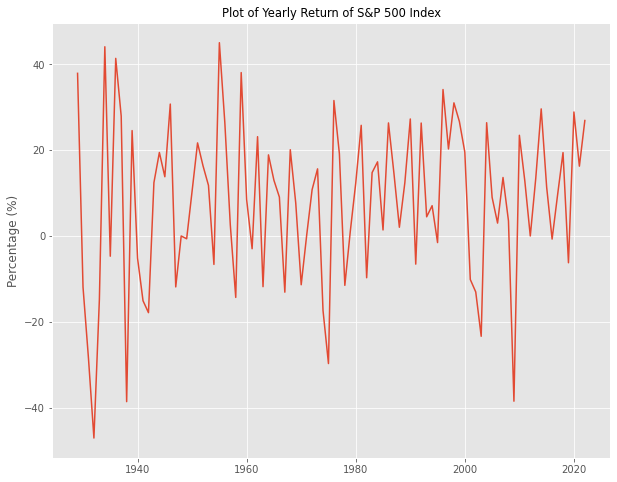

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.rcParams['font.size'] = 8
plt.plot(sp500_yearly_returns)
plt.title("Plot of Yearly Return of S&P 500 Index")
plt.ylabel("Percentage (%)")
#plt.savefig('Fig_1:sp500return.png', dpi=600)

#plt.savefig('Fig_1:return.png', dpi=300)
plt.show()

In [ ]:
import scipy.optimize as spop
import matplotlib.ticker as mtick


def garch_mle(theta,returns):

        mu = theta[0]
        omega = theta[1]
        alpha = theta[2]
        beta = theta[3]

    #calculating long-run volatility
        long_run = (omega/(1 - alpha - beta))**(1/2)
    #calculating realised and conditional volatility
        resid = returns - mu
        realised = abs(resid)
        conditional = np.zeros(len(returns))
        conditional[0] =  long_run
        for t in range(1,len(returns)):
            conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    #calculating log-likelihood
        likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
        log_likelihood = np.sum(np.log(likelihood))

        return -log_likelihood

def mle_opt(returns):

        mean = np.average(returns)
        var = np.std(returns)**2

        mle_param=spop.minimize(garch_mle, [mean, var, 0, 0], method='Nelder-Mead',
                args=returns)

        opt_params = mle_param.x

        return opt_params


def compare_model(returns,  opt_params):

    mu = opt_params[0]
    omega = opt_params[1]
    alpha = opt_params[2]
    beta = opt_params[3]



    long_run = (omega/(1 - alpha - beta))**(1/2)

    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] =  long_run
    for t in range(1,len(returns)):
                conditional[t] = (omega + alpha*resid[t-1]**2 +
                beta*conditional[t-1]**2)**(1/2)

    return realised, conditional

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


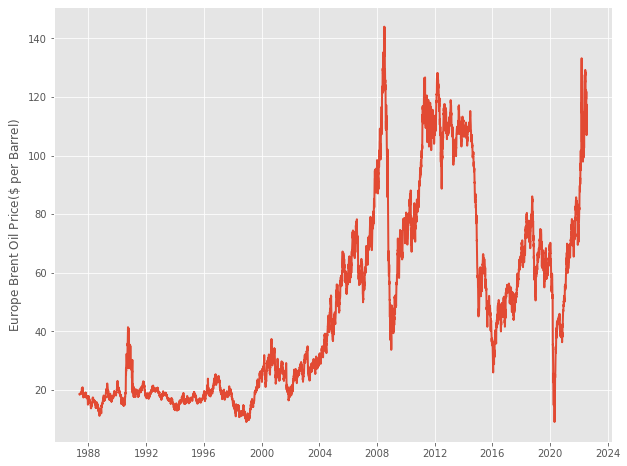

In [ ]:
Brent_crude_df = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls",
                sheet_name="Data 1")

#Brent_crude_df
def Brent_crude_process(Brent_crude):

     Brent_crude=Brent_crude.iloc[2:,]

     Brent_crude.columns= ["Date", "Dollar"]

     Brent_crude["Date"] = pd.to_datetime(Brent_crude["Date"])

     Brent_crude["Dollar"] = pd.to_numeric(Brent_crude["Dollar"])

     return Brent_crude.set_index("Date")



Brent_crude = Brent_crude_process(Brent_crude=Brent_crude_df)


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(Brent_crude["Dollar"], linewidth='2')
ax.set_ylabel(r'Europe Brent Oil Price($\$$ per Barrel)')
plt.savefig('Fig_2:oilprice.png', dpi=600)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


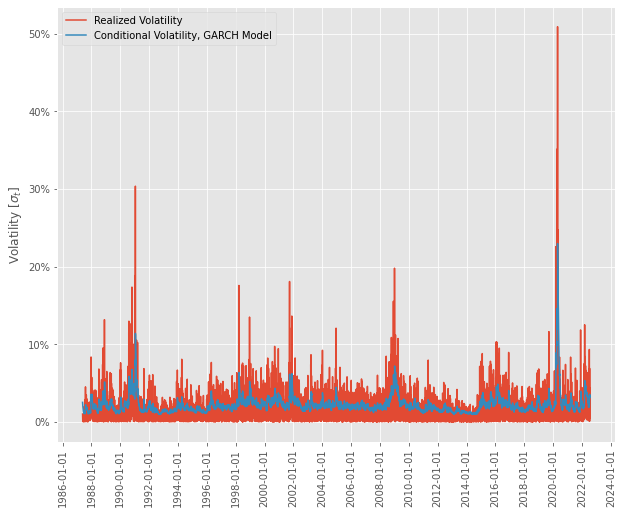

In [ ]:
Brent_crude_ret = np.array(100*Brent_crude["Dollar"].pct_change().dropna())
#Brent_crude_ret

#np.array(Brent_crude_ret)I
parms_opt_oil = mle_opt(returns=Brent_crude_ret)


realized_val, conditional_val = compare_model(returns=Brent_crude_ret,
                        opt_params=parms_opt_oil)

#len(realized_val)
#conditional_val

fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.size'] = 10


ax.plot(Brent_crude.index[1:] ,realized_val, label="Realized Volatility")
ax.plot(Brent_crude.index[1:], conditional_val,
                label = "Conditional Volatility, GARCH Model")
ax.legend(loc="upper left")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel(r'Volatility [$\sigma_t$]')
plt.show()

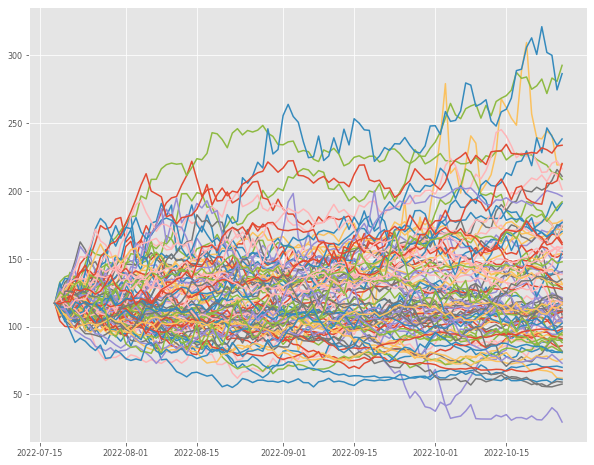

In [ ]:
import scipy.stats as ss

def generate_paths(num_time_steps,num_path_numbers, initial_date,
                initial_price, initial_vol,initial_res_vol, saved_params):

        T_steps = num_time_steps
        path_numbers = num_path_numbers


        mu = saved_params[0]
        omega = saved_params[1]
        alpha = saved_params[2]
        beta = saved_params[3]



        resid_sim = np.zeros((path_numbers, T_steps+1))
        resid_sim[:,0] = initial_res_vol

        conditional_sim = np.zeros((path_numbers, T_steps+1))
        conditional_sim[:,0] = initial_vol

        S = np.zeros((path_numbers, T_steps+1))
        S[:,0] = initial_price


        for path in range(path_numbers):

            for t in range(1, T_steps+1):

                conditional_sim[path,t] = (omega + alpha*resid_sim[path,t-1]**2 + beta*conditional_sim[path,t-1]**2)**(1/2)

                r = ss.norm.rvs(loc=mu, scale=conditional_sim[path,t])

                resid_sim[path, t] = r - mu

                S[path, t] = S[path,t-1]*(1+(r/100))

        return S



num_time_steps_val = 100

num_path_numbers_val =100

initial_date_val =  Brent_crude.index[-1]
initial_price_val= Brent_crude.loc[initial_date_val]["Dollar"]
initial_vol_val = conditional_val[-1]
initial_res_vol_val = realized_val[-1]



simulated_paths = generate_paths(num_time_steps=100, num_path_numbers=100,
                                        initial_price=initial_price_val,
                                        initial_date=initial_date_val,
                                        initial_vol=initial_res_vol_val,
                                        initial_res_vol=initial_res_vol_val,
                                        saved_params=parms_opt_oil)


date_length=pd.date_range(initial_date_val, periods=num_time_steps_val+1)




plt.rcParams['font.size'] = 8
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(date_length,simulated_paths.T)
plt.show()